In [1]:
import sys

sys.path.append('../')

import numpy as np
import torch
from matplotlib import pyplot as plt
from matplotlib import gridspec
from matplotlib.colors import Normalize, LogNorm
from torch.fft import fftshift, fft2, ifft2, ifftn, ifftshift
from tqdm import tqdm

from models.DAS import DAS
from models.PACT import PSF_PACT
from models.Wiener import Wiener_Batched
from utils.data import *
from utils.simulations import *
from utils.utils_torch import get_fourier_coord
from utils.reconstruction import wavefront_real, gaussian_kernel
from utils.visualization import *

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

data_path = '../data/'

### Load data

In [2]:
IP_img = load_mat(os.path.join(data_path, 'IP.mat'))
sinogram = load_mat(os.path.join(data_path, 'sinogram_simulation.mat'))
sinogram += np.random.normal(0, 1e-4, sinogram.shape)

### Preparations

In [3]:
Nx, Ny = 560, 560
dx, dy = 4e-5, 4e-5
kgrid = kWaveGrid([Nx, Ny], [dx, dy])
x_vec, y_vec = kgrid.x_vec, kgrid.y_vec
l = 3.2e-3 # Patch size [m].

In [4]:
R = 9.8e-3              # Radius of single body [m].
T = 26.0                # Water temperature [C].
v0 = get_water_SoS(T)   # Background SoS [m/s].
v1 = 1567.3             # Avergae SoS in single body [m/s].
print(v0, v1)

1499.3632858457756 1567.3


In [5]:
fwhm = 1.5e-3 # [m]
sigma = fwhm / 4e-5 / np.sqrt(2*np.log(2))
gaussian_window = torch.tensor(gaussian_kernel(sigma, 80), device=device)

Pick the small patch in the intil pressure image.

In [6]:
def get_coordinates(i, j, l):
    x, y = (j-12)*l / 4, (12-i)*l / 4
    r, phi = np.sqrt(x**2 + y**2), np.arctan2(x, y)
    return x, y, r, phi

i, j = 18, 15
x, y, r, phi = get_coordinates(i, j, l)
k2D, theta2D = get_fourier_coord(n_points=80, l=3.2e-3, device='cpu')
print(r*1e3, phi)

5.366563145999496 2.677945044588987


Define the delays for reconstruction and the elays for visualization, which is a subset of the former.

In [7]:
delays = np.arange(-8e-4, 8e-4, 5e-5)
ids_show = [12, 16, 20, 24, 28]
delays_show = delays[ids_show]
print(delays_show)

[-2.00000000e-04  3.25260652e-19  2.00000000e-04  4.00000000e-04
  6.00000000e-04]


### Conventional DAS

In [8]:
das = DAS(R_ring=0.05, N_transducer=512, T_sample=1/40e6, x_vec=x_vec, y_vec=y_vec, mode='zero', device=device)
das.to(device)
das.eval()

DAS()

In [9]:
with torch.no_grad():
    rec_das = das(sinogram=torch.tensor(sinogram, device=device), 
             v0=torch.tensor(1513.0, device=device),
             d_delay=torch.zeros(1, device=device),
             ring_error=torch.zeros(1, device=device)).detach().cpu().numpy()

In [10]:
rec_das = rec_das[20*i:20*i+80, 20*j:20*j+80]

### Single Body

In [11]:
psf_pact = PSF_PACT(n_points=80, l=l, n_delays=delays.shape[0], device=device)
psf_pact.to(device)
psf_pact.eval()

das = DAS(R_ring=0.05, N_transducer=512, T_sample=1/40e6, x_vec=x_vec, y_vec=y_vec, mode='zero', device=device)
das.to(device)
das.eval()

wiener = Wiener_Batched(lam=5., device=device)
wiener.to(device)
wiener.eval()

Wiener_Batched()

In [12]:
img_stack = []
with torch.no_grad():
    for d_delay in tqdm(delays, desc='DAS'):
        recon = das(sinogram=torch.tensor(sinogram).to(device), 
                    v0=torch.tensor(v0, device=device),
                    d_delay=torch.tensor(d_delay, device=device),
                    ring_error=torch.zeros(1, device=device))
        img_stack.append(recon)
img_stack = torch.stack(img_stack, dim=0)

DAS: 100%|██████████| 32/32 [00:05<00:00,  5.47it/s]


In [13]:
gt = IP_img[20*i:20*i+80, 20*j:20*j+80]
w_real = wavefront_real(R, r, phi, v0, v1)
psf_stack = psf_pact(torch.tensor(delays, device=device).view(1,-1,1,1), w_real)
obs_stack = img_stack[:,20*i:20*i+80, 20*j:20*j+80].unsqueeze(0)
mean = obs_stack.abs().mean()
rec_combined = wiener(obs_stack/mean, psf_stack) * mean
rec_combined = rec_combined.squeeze(0).squeeze(0).detach().cpu().numpy()

In [14]:
recs = []
for idx, delay in zip(ids_show, delays_show):
    psf = psf_stack[:,idx:idx+1,:,:]
    obs = obs_stack[:,idx:idx+1,:,:]
    mean = obs.mean()
    rec = wiener(obs/mean, psf) * mean
    rec = rec.squeeze(0).squeeze(0).detach().cpu().numpy()
    recs.append(rec)

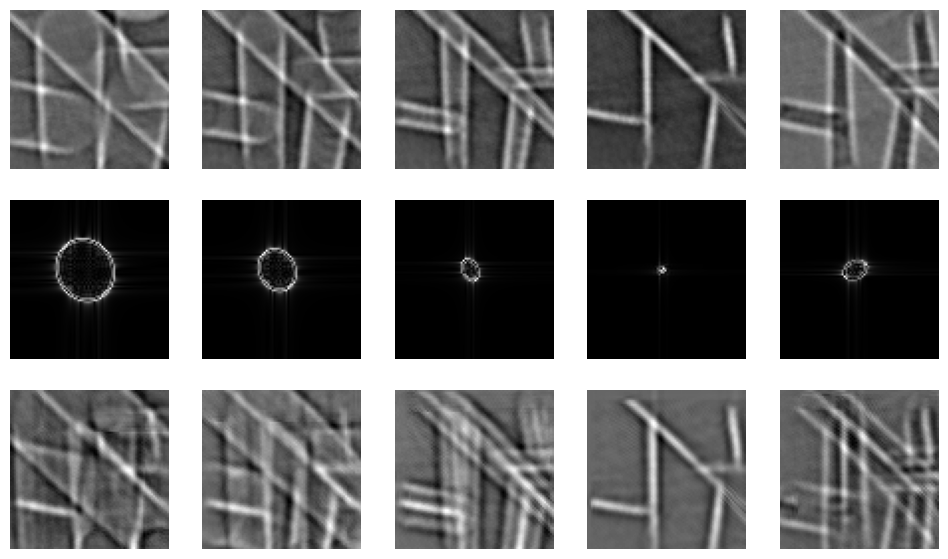

In [15]:
plt.subplots(3, 5, figsize=(12, 7))
for k, (idx, rec) in enumerate(zip(ids_show, recs)):
    plt.subplot(3, 5, k+1)
    plt.imshow(obs_stack[:,idx,:,:].squeeze(0).detach().cpu().numpy(), cmap='gray')
    plt.axis('off')
    
    plt.subplot(3, 5, k+6)
    plt.imshow(psf_stack[:,idx,:,:].squeeze(0).detach().cpu().numpy(), cmap='gray')
    plt.axis('off')
    
    plt.subplot(3, 5, k+11)
    plt.imshow(rec, cmap='gray')
    plt.axis('off')

In [16]:
def PSF(theta, k, w, delay):
    tf = (torch.exp(-1j*k*(delay - w(theta))) + torch.exp(1j*k*(delay - w(theta+torch.pi)))) / 2
    psf = ifftshift(ifft2(fftshift(tf, dim=[-2,-1])), dim=[-2,-1]).abs()
    psf /= psf.sum(axis=(-2,-1)) # Normalization.
    return psf

def TF(theta, k, w, delay):
    tf = (torch.exp(-1j*k*(delay - w(theta))) + torch.exp(1j*k*(delay - w(theta+np.pi)))) / 2
    return tf

def condition_number(psf):
    """Calculate the condition number of a PSF.

    Args:
        tf (`numpy.ndarray`): PSF image.

    Returns:
        `float`: Condition number.
    """
    H = fft2(psf)
    return H.abs().max() / H.abs().min()    

In [17]:
recs = [normalize(img) for img in recs]
[rec_das, rec_combined, gt] = [normalize(img) for img in [rec_das, rec_combined, gt]]

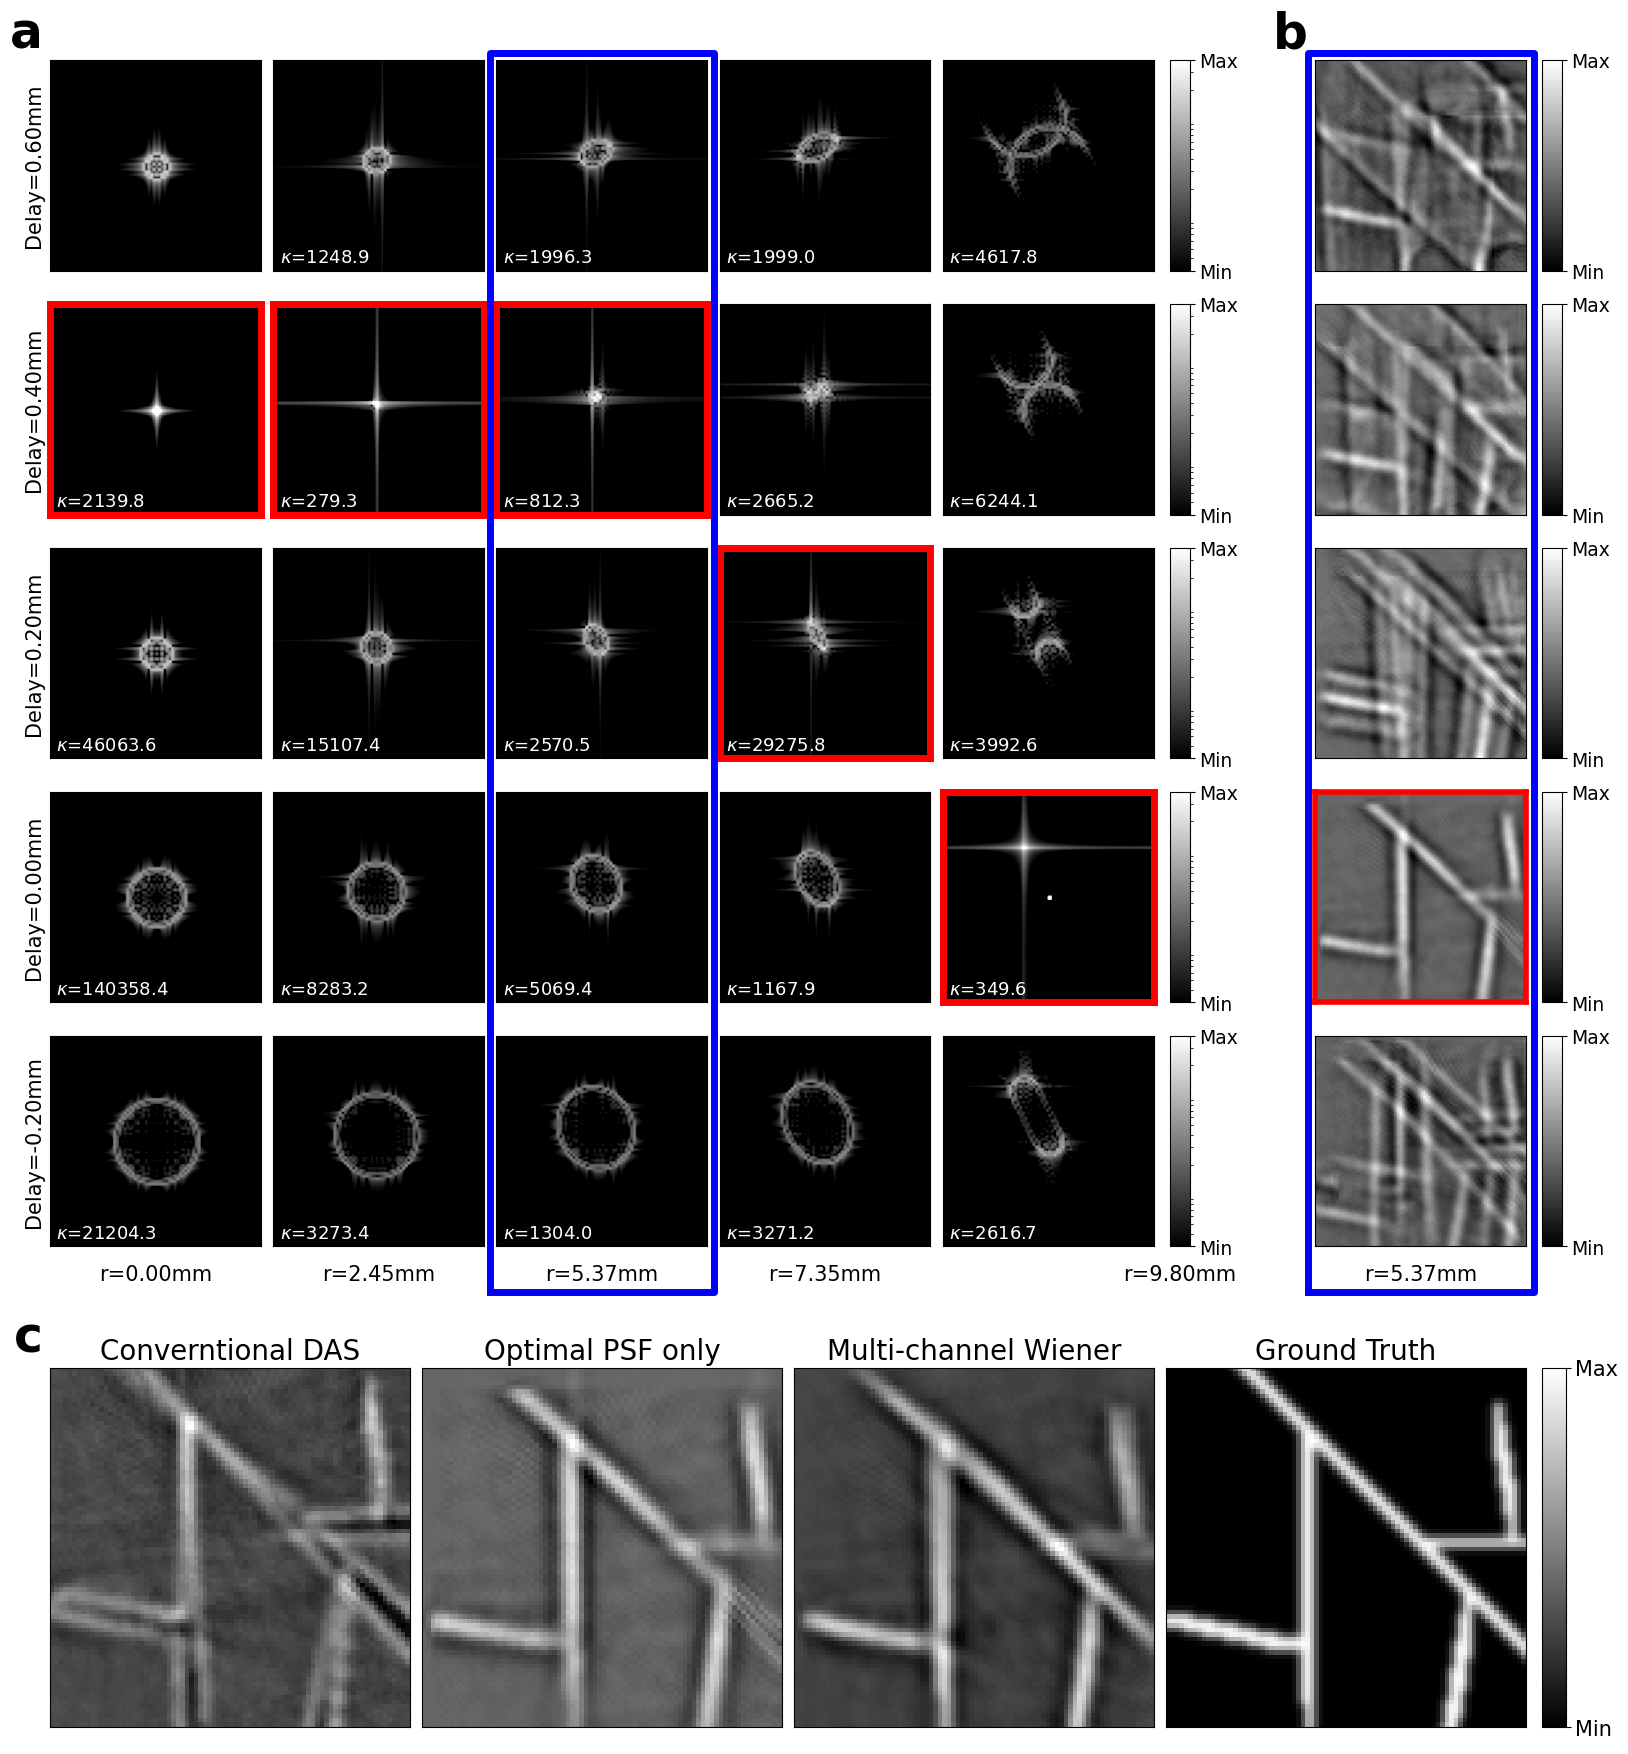

In [31]:
rs = [0, R/4, r, 3*R/4, R]
best_ids = [3,3,3,2,1]

fig, main_ax = plt.subplots(figsize=(20, 22))
gs = gridspec.GridSpec(21, 21)
norm_img = Normalize(vmin=0, vmax=1)
norm_psf = LogNorm(vmin=3e-4, vmax=0.04)
for i, r_i in enumerate(rs):
    w_real = wavefront_real(R, r_i, phi, v0, v1)
    for j, delay in enumerate(delays_show):
        psf = PSF(theta2D, k2D, w_real, delay)
        psf = np.maximum(psf, 1e-9)
        ax = plt.subplot(gs[12-3*j:15-3*j,3*i:3*(i+1)])
        plt.imshow(psf, cmap='gray', norm=norm_psf)
        plt.xticks([])
        plt.yticks([])
        plt.title('$\kappa$={:.1f}'.format(condition_number(psf)), fontsize=13, loc='left', y=0.0, x=0.03, color='white')
        if i == 0:
            plt.ylabel('Delay={:.2f}mm'.format(delays_show[j]*1e3), fontsize=15)
            if j == 4:
                plt.title('a', loc='left', x=-0.19, y=1.02, fontsize=35, fontweight='bold', color='black')
        elif i == 4:
            cax = fig.add_axes([ax.get_position().x1+0.008, ax.get_position().y0, 0.01, ax.get_position().height])
            cb = plt.colorbar(cax=cax)
            cb.set_ticks([3e-4, 0.04])
            cb.set_ticklabels(['Min', 'Max'], fontsize=13.5)
        if j == 0:
            plt.title('r={:.2f}mm'.format(r_i*1e3), fontsize=15, y=-0.2)
        if j == best_ids[i]:
            for loc in ['bottom', 'top', 'left', 'right']:
                ax.spines[loc].set_color('red')
                ax.spines[loc].set_linewidth(5)

                
for j, delay in enumerate(delays_show):
    ax = plt.subplot(gs[3*j:3*(j+1),17:20])
    plt.xticks([])
    plt.yticks([])
    plt.imshow(recs[j], cmap='gray', norm=norm_img)
    if j == 0:
        plt.title('b', loc='left', x=-0.2, y=1.02, fontsize=35, fontweight='bold', color='black')
    elif j == best_ids[2]:
        for loc in ['bottom', 'top', 'left', 'right']:
            ax.spines[loc].set_color('red')
            ax.spines[loc].set_linewidth(4)
    elif j == 4:
         plt.title('r={:.2f}mm'.format(rs[2]*1e3), fontsize=15, y=-0.2)
    cax = fig.add_axes([ax.get_position().x1+0.008, ax.get_position().y0, 0.01, ax.get_position().height])
    cb = plt.colorbar(cax=cax)
    cb.set_ticks([0, 1])
    cb.set_ticklabels(['Min', 'Max'], fontsize=13.5)

for j, (img, title) in enumerate(zip([rec_das, recs[best_ids[2]], rec_combined, gt], ['Converntional DAS', 'Optimal PSF only', 'Multi-channel Wiener', 'Ground Truth'])):
    ax = plt.subplot(gs[16:21,5*j:5*(j+1)])
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img, cmap='gray', norm=norm_img)
    plt.title(title, fontsize=20)
    if j == 0:
        plt.title('c', loc='left', x=-0.1, y=1.02, fontsize=35, fontweight='bold', color='black')
    elif j == 3:
        cax = fig.add_axes([ax.get_position().x1+0.008, ax.get_position().y0, 0.012, ax.get_position().height])
        cb = plt.colorbar(cax=cax)
        cb.set_ticks([0, 1])
        cb.set_ticklabels(['Min', 'Max'], fontsize=15)

main_ax.set_zorder(20)
main_ax.axis('off')
main_ax.set_xlim(0, 21)
main_ax.set_ylim(0, 21)
y1, y2 = 5.6, 20.96
x1, x2 = 5.96, 8.99
x3, x4 = 17.04, 20.1
main_ax.plot([x1, x1, x2, x2, x1], [y1, y2, y2, y1, y1], color='blue', linewidth=5)
main_ax.plot([x3, x3, x4, x4, x3], [y1, y2, y2, y1, y1], color='blue', linewidth=5)

plt.savefig('figure_refocusing.png', dpi=256, bbox_inches='tight')